# Load Data for Modelling

In [1]:
"""This notebook fits a GLM and a Linear Regression to evaluate predictors' influence on lateness"""
import os
from pathlib import Path
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import yaml
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV


# After the first fit, features that don't provide strong predictive power were removed
features_list = [
    "route_variant",
    "direction",           
    "transit_stop_sequence",
    "suburb",
    "bus_configuration",
    "seated_capacity",        
    "standing_capacity",
    "is_weekend",             
    "timetable_hr_sin",
    "timetable_hr_cos",
    "timetable_min_sin",
    "timetable_min_cos",
    "day_of_week_sin",
    "day_of_week_cos",
    "lateness_minutes"
]


config_path = Path.cwd().parent / "config.yaml"
with open("config.yaml",  encoding="utf-8") as f:
    config = yaml.safe_load(f)
df_path = config["processed_path"] + "sample_100k.csv"


df = pd.read_csv(df_path, usecols=features_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100446 entries, 0 to 100445
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   route_variant          100446 non-null  object 
 1   direction              100446 non-null  object 
 2   transit_stop_sequence  100446 non-null  int64  
 3   suburb                 100446 non-null  object 
 4   bus_configuration      100446 non-null  object 
 5   seated_capacity        100446 non-null  int64  
 6   standing_capacity      100446 non-null  int64  
 7   is_weekend             100446 non-null  int64  
 8   timetable_hr_sin       100446 non-null  float64
 9   timetable_hr_cos       100446 non-null  float64
 10  timetable_min_sin      100446 non-null  float64
 11  timetable_min_cos      100446 non-null  float64
 12  day_of_week_sin        100446 non-null  float64
 13  day_of_week_cos        100446 non-null  float64
 14  lateness_minutes       100446 non-nu

# Features Encoding 

In [2]:
# Cardinality checking
for col in df.columns:
    if df[col].apply(type).eq(str).all():
        print(f"{col}: {df[col].nunique()} unique values")

route_variant: 9982 unique values
direction: 3 unique values
suburb: 1083 unique values
bus_configuration: 7 unique values


## Encoders

In [3]:
# One-hot for low-cardinality features
onehot_cols = ["direction", "bus_configuration", "route_variant", "suburb"]

# Ordinal encode sequences
ordinal_cols = ["transit_stop_sequence"]

# Standardising numerical columns
standardise_cols = [col for col in df.columns if col not in ordinal_cols + onehot_cols and col != "lateness_minutes"]

In [4]:
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"), onehot_cols),
        ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ordinal_cols),
        ("scaler", StandardScaler(), standardise_cols)
    ],
    remainder="passthrough"  # Keep other columns as-is
)

## Train-test Split

In [5]:
X = df.drop("lateness_minutes", axis = 1)
y = df["lateness_minutes"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=None)

# Model Training and Evaluation

In [6]:
linear_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("lr", LinearRegression())
])

glm_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("glm",  TweedieRegressor(power=0))
])

# Define parameter grids for each model separately
linear_param_grid = {
    "lr__fit_intercept": [True, False],
}

glm_param_grid = {
    "glm__alpha": [0.001, 0.01, 0.1, 1.0], 
    "glm__fit_intercept": [True, False],
    "glm__max_iter": [3000, 5000]
}

In [7]:
print("Running GridSearchCV for Linear Regression...")
linear_grid_search = GridSearchCV(
    linear_pipeline,
    param_grid=linear_param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    refit=True,
    return_train_score=True,
    verbose=1
)

linear_grid_search.fit(X_train, y_train)

Running GridSearchCV for Linear Regression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/home/mhl/traffic-agent/.dev_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/mhl/traffic-agent/.dev_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/mhl/traffic-agent/.dev_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/mhl/traffic-agent/.dev_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/mhl/tr

,estimator,Pipeline(step...egression())])
,param_grid,"{'lr__fit_intercept': [True, False]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('onehot', ...), ('ordinal', ...), ...]"


In [8]:
print("Running GridSearchCV for GLM...")
glm_grid_search = GridSearchCV(
    glm_pipeline,
    param_grid=glm_param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    refit=True,
    return_train_score=True,
    verbose=1
)

glm_grid_search.fit(X_train, y_train)

Running GridSearchCV for GLM...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/mhl/traffic-agent/.dev_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/mhl/traffic-agent/.dev_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/mhl/traffic-agent/.dev_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/mhl/traffic-agent/.dev_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/mhl/tr

,estimator,Pipeline(step...or(power=0))])
,param_grid,"{'glm__alpha': [0.001, 0.01, ...], 'glm__fit_intercept': [True, False], 'glm__max_iter': [3000, 5000]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('onehot', ...), ('ordinal', ...), ...]"


In [9]:
# Access the best fits
best_linear_model = linear_grid_search.best_estimator_
best_glm_model = glm_grid_search.best_estimator_


# Make predictions
train_pred_glm = best_glm_model.predict(X_train)
test_pred_glm = best_glm_model.predict(X_test)
train_pred_linear = best_linear_model.predict(X_train)
test_pred_linear = best_linear_model.predict(X_test)

/home/mhl/traffic-agent/.dev_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/mhl/traffic-agent/.dev_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


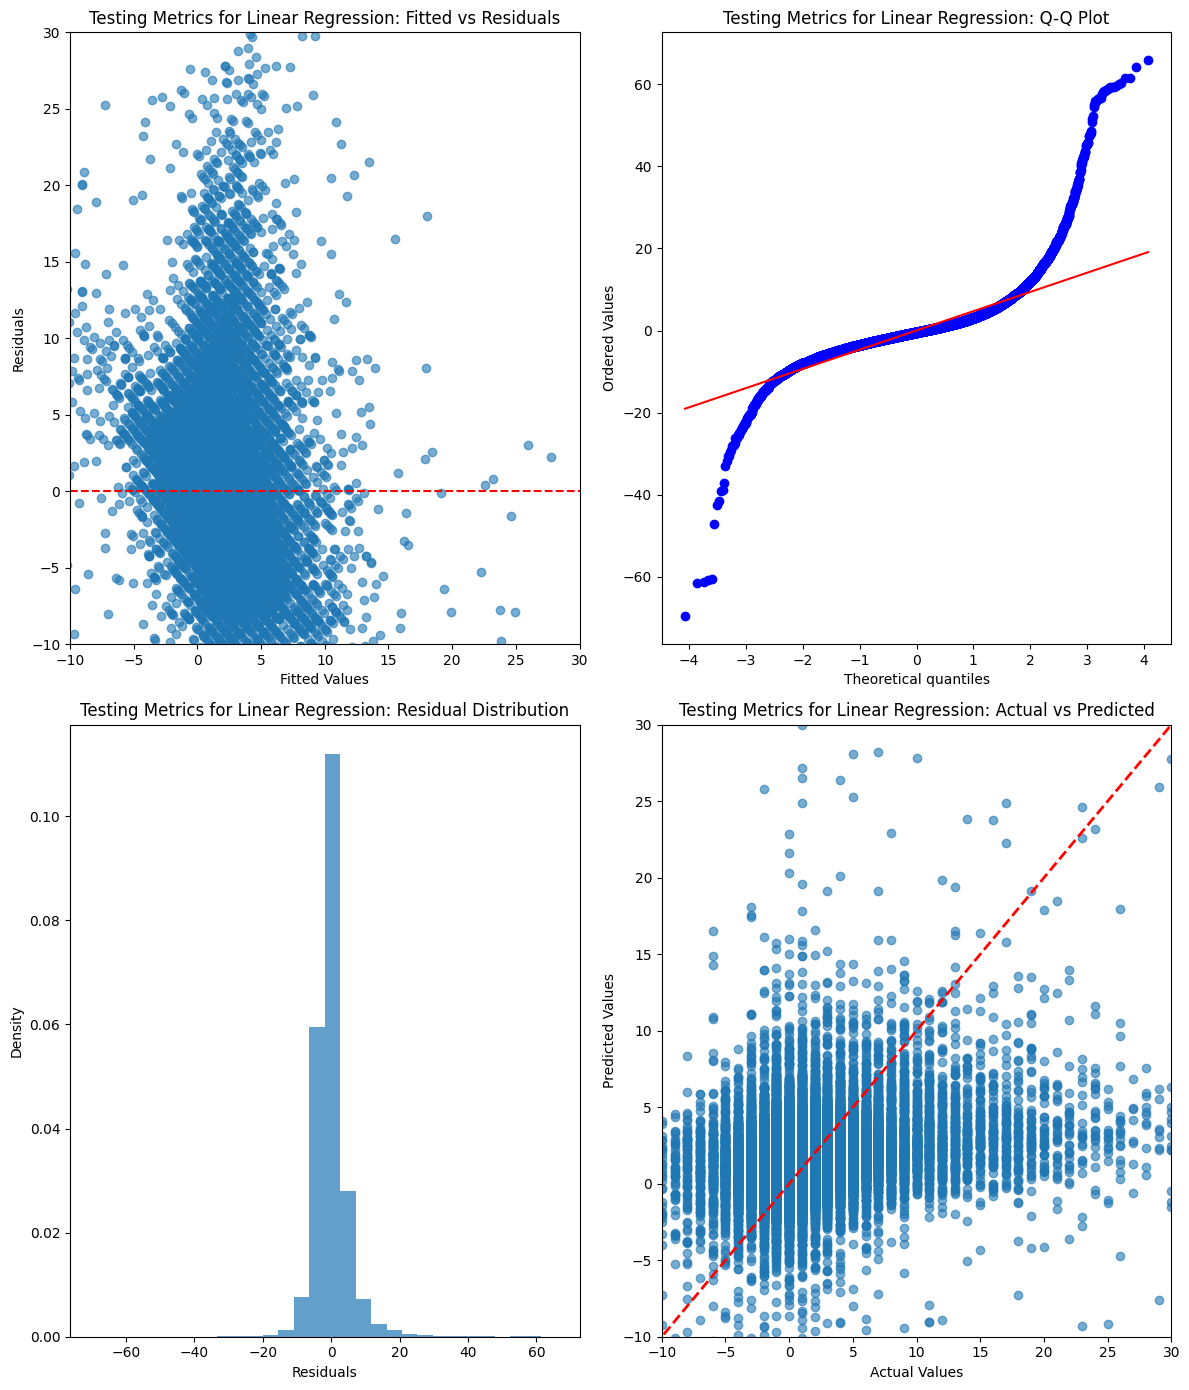

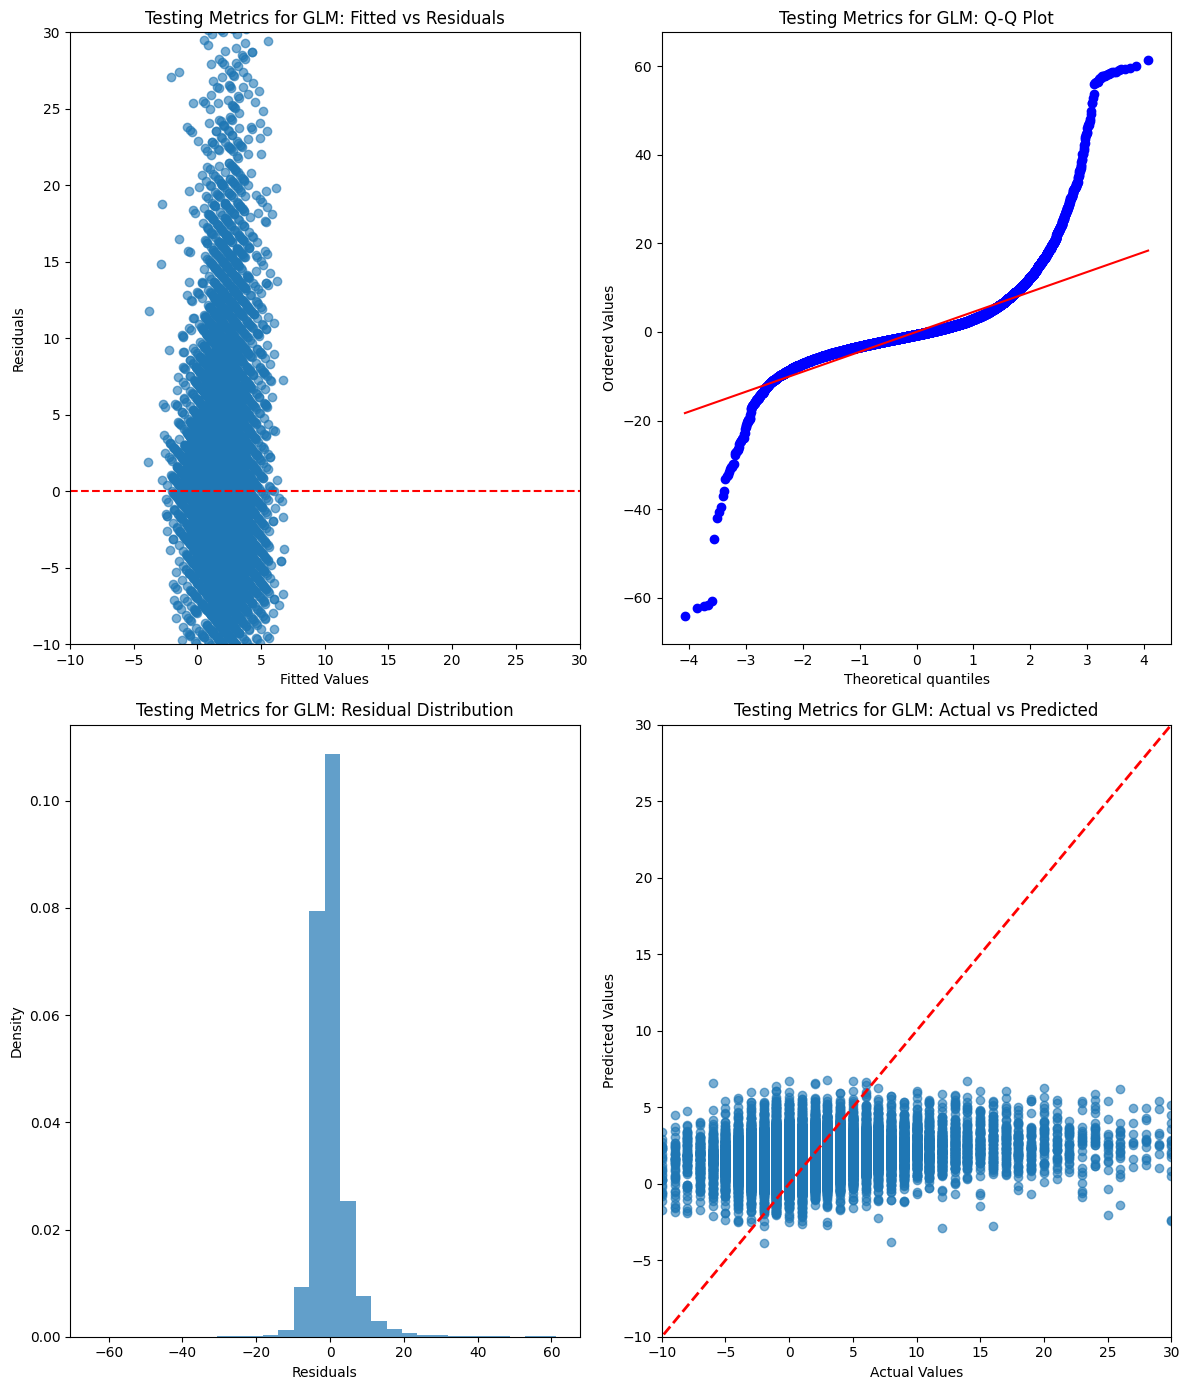

In [10]:
# Diagnostic plots functions
def plot_regression_diagnostics(model, y, y_pred, title_prefix="", model_name="lr"):
    """ Create diagnostic plots for linear regression"""
    fig, axes=plt.subplots(2, 2, figsize=(12, 14))
    
    # 1. Fitted vs Residuals
    residuals = y - y_pred
    axes[0, 0].scatter(y_pred, residuals, alpha=0.6)
    axes[0, 0].axhline(y=0, color="r", linestyle="--")
    axes[0, 0].set_xlabel("Fitted Values")
    axes[0, 0].set_ylabel("Residuals")
    axes[0, 0].set_title(f"{title_prefix}Fitted vs Residuals")
    axes[0, 0].set_ylim([-10, 30])
    axes[0, 0].set_xlim([-10, 30])
    
    # 2. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title(f"{title_prefix}Q-Q Plot")
    
    # 3. Histogram of Residuals
    axes[1, 0].hist(residuals, bins=30, alpha=0.7, density=True)
    axes[1, 0].set_xlabel("Residuals")
    axes[1, 0].set_ylabel("Density")
    axes[1, 0].set_title(f"{title_prefix}Residual Distribution")
    
    # 4. Actual vs Predicted
    axes[1, 1].scatter(y, y_pred, alpha=0.6)
    axes[1, 1].plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)
    axes[1, 1].set_xlabel("Actual Values")
    axes[1, 1].set_ylabel("Predicted Values")
    axes[1, 1].set_xlim([-10, 30])
    axes[1, 1].set_ylim([-10, 30])
    axes[1, 1].set_title(f"{title_prefix}Actual vs Predicted")
    
    plt.tight_layout()
    plt.savefig(f"{model_name}_results.png")


# Print coefficients and statistics
def print_model_summary(model, X_train, y_train, y_test, y_train_pred, y_test_pred, model_name="lr"):
    base_name = "metrics"
    extension = ".txt"
    file_name = base_name +"_" + model_name + extension
    counter = 1
    while os.path.exists(file_name):
        file_name = f"{base_name}_{model_name}-{counter}{extension}"
        counter += 1
    with open(file_name, mode="x", encoding="utf-8") as f:
        print("=== Regression Results ===", file=f)
        print(f"R² (Train): {r2_score(y_train, y_train_pred):.4f}", file=f)
        print(f"R² (Test): {r2_score(y_test, y_test_pred):.4f}", file=f)
        print(f"RMSE (Train): {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}", file=f)
        print(f"RMSE (Test): {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}", file=f)
        
        print("\n=== Feature Coefficients ===", file=f)
        coef_df=pd.DataFrame({
            "Feature": model.named_steps["preprocessor"].get_feature_names_out(),
            "Coefficient": model.named_steps[f"{model_name}"].coef_,
            "Abs_Coefficient": np.abs(model.named_steps[f"{model_name}"].coef_)
        }).sort_values("Coefficient", ascending=False)
        
        print(coef_df.to_string(index=False), file=f)
        print(f"\nIntercept: {model.named_steps[f'{model_name}'].intercept_:.4f}", file=f)


if __name__ == "__main__":
    plot_regression_diagnostics(best_linear_model, y_test, test_pred_linear, "Testing Metrics for Linear Regression: ")
    plot_regression_diagnostics(best_glm_model, y_test, test_pred_glm, "Testing Metrics for GLM: ", "glm")
    print_model_summary(best_glm_model, X_train, y_train, y_test, train_pred_glm, test_pred_glm, model_name= "glm" )
    print_model_summary(best_linear_model, X_train, y_train, y_test, train_pred_linear, test_pred_linear)